# Setup

In [2]:
from transformer_lens.cautils.notebook import *

from transformer_lens.rs.callum.keys_fixed import (
    project,
    get_effective_embedding_2,
)

from transformer_lens.rs.callum.orthogonal_query_investigation import (
    decompose_attn_scores_full,
    create_fucking_massive_plot_1,
    create_fucking_massive_plot_2,
    token_to_qperp_projection
)

clear_output()

In [3]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    # "solu-10l",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    # refactor_factored_attn_matrices=True,
)
model.set_use_split_qkv_input(False)
model.set_use_attn_result(True)
model.set_use_split_qkv_normalized_input(False)
# model.cfg.use_hook_tokens = True
# model.use_hook_

clear_output()

# sudo pkill -9 python

In [4]:
data = get_webtext(seed=6)
clear_output()

In [24]:
self_attn = [-1, -3, -2, -4, -5, -4, -2.5, -4.5, -3.5]
self_attn = t.tensor(self_attn).float().reshape(3, 3) #.exp()

text_Q = ["W<sub>U</sub>", "MLP<sub>0</sub>", "W<sub>EE</sub>"]
text_K = ["W<sub>EE</sub>", "W<sub>E</sub>", "MLP<sub>0</sub>"]
text = [[f"Q = {q}<br>K = {k}" for k in text_K] for q in text_Q]

fig = imshow(
    self_attn,
    title = "Average self-attention scores for 10.7 (using bag of words)",
    return_fig = True,
    height=550,
    width=650,
    color_continuous_scale="RdBu_r"
)
fig.data[0].update(
    text=text, 
    texttemplate="%{text}", 
    textfont={"size": 12}
)
fig.show()

# Calibration

Key questions:

* When the model says it's x% confident that a token comes next, how often does that token actually come next?
* How does this change when you remove the direct effect of a head?

In [4]:
def perfect_calibration_line(n_bins) -> Float[Tensor, "n_bins"]:
    return (t.arange(n_bins) + 0.5) / n_bins

def perfect_overconfidence_line(n_bins) -> Float[Tensor, "n_bins"]:
    return t.full((n_bins,), fill_value=0.5)

def my_line(
    y: Float[Tensor, "n_bins"],
    y_upper: Optional[Float[Tensor, "n_bins"]] = None,
    y_lower: Optional[Float[Tensor, "n_bins"]] = None,
    title: Optional[str] = None,
):
    x = list(range(len(y)))
    fig = go.Figure([go.Scatter(
        y=y,
        x=x,
        line=dict(color='rgb(0,100,80)'),
        mode='lines'
    )])
    if (y_upper is not None) and (y_lower is not None):
        fig.add_trace(go.Scatter(
            x=x+x[::-1], # x, then x reversed
            y=y_upper+y_lower[::-1], # upper, then lower reversed
            fill='toself',
            fillcolor='rgba(0,100,80,0.2)',
            line=dict(color='rgba(255,255,255,0)'),
            hoverinfo="skip",
            showlegend=False
        ))
    if min(y) >= 0:
        yaxis_range = [0, 1]
    else:
        y_max = max(max(y_upper), -min(y_lower))
        yaxis_range = [-y_max, y_max]
    fig.update_layout(
        width=800,
        height=600,
        showlegend=False,
        title=title if title is not None else "",
        xaxis_range=[0, len(y)],
        yaxis_range=yaxis_range
    )
    fig.show()

In [16]:
def calculate_overconfidence(accuracy: Float[Tensor, "n_bins"]):
    '''
    Quantifies overconfidence from an accuracy curve.

    This metric is:
        0 if the model is perfectly calibrated (i.e. says something has X% prob implies it always happens with frequency X)
        1 if the model is as overconfident as it could be without being inaccurate (it always assigns 50% probability to the less likely outcome)
        -1 if the model is as underconfident as it could be without being inaccurate
    
    underconfident_sigmoid = t.linspace(-5, 5, 100).sigmoid()
    calculate_overconfidence(underconfident_sigmoid) -> about -0.7
    '''
    n_bins = len(accuracy)

    f = accuracy - perfect_calibration_line(n_bins).to(accuracy.device)
    x = perfect_overconfidence_line(n_bins).to(accuracy.device) - perfect_calibration_line(n_bins).to(accuracy.device)

    return (f * x).sum() / (x * x).sum()


def measure_calibration(
    model: HookedTransformer,
    num_batches: int = 20,
    batch_size: int = 100,
    seq_len: int = 250,
    data_source: Literal["OWT", "IOI"] = "OWT",
    top_k: int = 3,
    n_bins: int = 50,
    plot_calibration_curve: bool = False,
):
    assert data_source in ["OWT", "IOI"]

    def get_batch(i):
        if data_source == "OWT":
            assert num_batches * batch_size <= len(data)
            return model.to_tokens(data[batch_size*i: batch_size*(i+1)])[:, :seq_len]
        else:
            return generate_data_and_caches(batch_size, model=model, seed=i, only_ioi=True, prepend_bos=True, return_cache=False).toks

    bucket_frequency = t.zeros(n_bins)
    bucket_correct_frequency = t.zeros(n_bins)

    for j in tqdm(range(num_batches)):

        t.cuda.empty_cache()

        toks = get_batch(j)
        logits: Float[Tensor, "batch seq d_vocab"] = model(toks, return_type="logits")[:, :-1]
        probs = logits.softmax(-1)

        next_toks = toks[:, 1:]

        topk_probs = probs.topk(k=top_k, dim=-1)
        topk_probs_values: Float[Tensor, "batch seq k"] = topk_probs.values
        topk_probs_indices: Int[Tensor, "batch seq k"] = topk_probs.indices
        
        # Figure out all the indices where the model was correct
        mask_is_correct: Bool[Tensor, "batch seq k"] = (topk_probs_indices == next_toks.unsqueeze(-1))

        for i in t.arange(n_bins):
            p_lower = i / n_bins
            p_upper = (i + 1) / n_bins
            # Figure out the indices of all values which are predicted for this probability
            mask_is_in_probability_bucket = (topk_probs_values >= p_lower) & (topk_probs_values < p_upper)
            # Calculate how many were correct
            bucket_frequency[i] = mask_is_in_probability_bucket.sum()
            bucket_correct_frequency[i] = (mask_is_in_probability_bucket & mask_is_correct).sum()

    accuracy = bucket_correct_frequency / bucket_frequency

    bucket_probs = (t.arange(n_bins) + 0.5) / n_bins
    variance = bucket_probs * (1 - bucket_probs) / bucket_frequency

    if plot_calibration_curve:
        y_upper = accuracy + variance.sqrt()
        y_lower = accuracy - variance.sqrt()
        my_line(accuracy.tolist(), y_upper.tolist(), y_lower.tolist(), title="Calibration curve")

    return accuracy, variance

In [6]:
# accuracy, variance = measure_calibration(
#     model,
#     n_bins = 40, # 100
#     num_batches = 20, # 20,
#     batch_size = 150, # 100,
#     seq_len = 100, # 250,
#     plot_calibration_curve = True,
# )

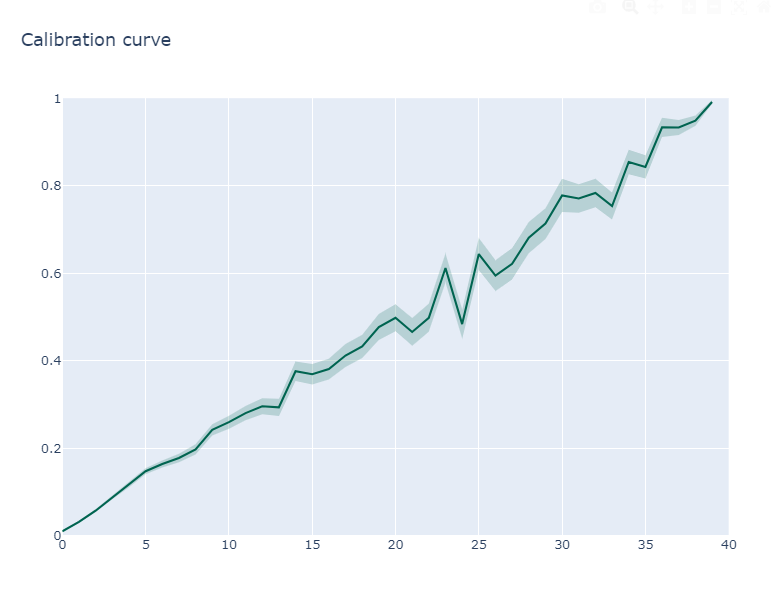

In [9]:
def measure_calibration_minus_heads(
    model: HookedTransformer,
    head_list: List[Tuple[int, int]],
    num_batches: int = 40,
    batch_size: int = 64,
    seq_len: int = 128,
    data_source: Literal["OWT", "IOI"] = "OWT",
    top_k: int = 5,
    n_bins: int = 100,
):
    assert data_source in ["OWT", "IOI"]

    def get_batch(i):
        if data_source == "OWT":
            assert num_batches * batch_size <= len(data)
            return model.to_tokens(data[batch_size*i: batch_size*(i+1)])[:, :seq_len]
        else:
            return generate_data_and_caches(batch_size, model=model, seed=i, only_ioi=True, prepend_bos=True, return_cache=False).toks

    bucket_frequency: Int[Tensor, "heads bins"] = t.zeros(len(head_list) + 1, n_bins).to(device)
    bucket_correct_frequency: Int[Tensor, "heads bins"] = t.zeros(len(head_list) + 1, n_bins).to(device)

    progress_bar = tqdm(total=num_batches * (len(head_list) + 2))

    t_all = {"total1": 0.0, "total2": 0.0, "rest": t.zeros(4), "z": t.zeros(3)}

    for j in range(num_batches):

        t0 = time.time()

        toks = get_batch(j)
        next_toks = einops.repeat(toks[:, 1:], "batch seq -> batch seq k", k=top_k)

        logits, cache = model.run_with_cache(
            toks,
            names_filter=lambda name: name.endswith("result") or name == utils.get_act_name("scale"),
            return_type="logits"
        )
        logits = logits[:, :-1]
        ln_final_scale = cache["scale"][:, :-1]

        progress_bar.update(1)

        t1 = time.time()

        t_all["total1"] += (t1 - t0)

        for i, head in enumerate([None] + head_list):
            
            if head is None:
                new_logits = logits
            else:
                layer, head_idx = head
                # z = cache["z", layer][:, :-1, head_idx]
                t0 = time.time()
                # result = einops.einsum(z, model.W_O[layer, head_idx], "batch seq d_head, d_head d_model -> batch seq d_model")
                result = cache["result", layer][:, :-1, head_idx] / ln_final_scale
                t1 = time.time()
                logit_contribution = einops.einsum(result, model.W_U, "batch seq d_model, d_model d_vocab -> batch seq d_vocab")
                t2 = time.time()
                new_logits = logits - logit_contribution
                t3 = time.time()
                t_all["z"][0] += t1 - t0
                t_all["z"][1] += t2 - t1
                t_all["z"][2] += t3 - t2
            
            t2 = time.time()

            probs = new_logits.softmax(-1)

            topk_probs = probs.topk(k=top_k, dim=-1)
            topk_probs_values: Float[Tensor, "batch seq k"] = topk_probs.values
            topk_probs_indices: Int[Tensor, "batch seq k"] = topk_probs.indices
            t3 = time.time()
        
            # Figure out all the indices where the model was correct
            # print(topk_probs_indices.device, topk_probs_indices.dtype, topk_probs_indices.shape)
            # print(next_toks.device, next_toks.dtype, next_toks.shape)
            mask_is_correct: Bool[Tensor, "batch seq k"] = (topk_probs_indices - next_toks) == 0

            t4 = time.time()
            prob_bins = einops.repeat(
                t.arange(n_bins + 1, device=device) / n_bins,
                "bins -> 1 1 1 bins"
            )
            t5 = time.time()

            mask_is_in_prob_bin: Bool[Tensor, "batch seq k bins"] = (topk_probs_values.unsqueeze(-1) >= prob_bins[..., :-1]) & (topk_probs_values.unsqueeze(-1) < prob_bins[..., 1:])
            bucket_frequency[i, :] += einops.reduce(mask_is_in_prob_bin, "batch seq k bins -> bins", "sum")
            bucket_correct_frequency[i, :] += einops.reduce(mask_is_in_prob_bin * mask_is_correct.unsqueeze(-1), "batch seq k bins -> bins", "sum")

            t6 = time.time()
            t_all["rest"] += t.tensor((t6 - t5, t5 - t4, t4 - t3, t3 - t2))
            progress_bar.update(1)

            # if t_all["rest"].sum() + t_all["total1"] + t_all["total2"] + t_all["z"].sum() > 10:
            #     print(t_all)

    accuracy = bucket_correct_frequency / bucket_frequency

    bucket_probs = (t.arange(n_bins).to(device) + 0.5) / n_bins
    variance = bucket_probs * (1 - bucket_probs) / bucket_frequency

    return accuracy, variance

In [19]:
head_list=[
    (layer, head)
    for layer in range(model.cfg.n_layers)
    for head in range(model.cfg.n_heads)
]

t.cuda.empty_cache()
accuracy_all, variance_all = measure_calibration_minus_heads(
    model,
    head_list=head_list,
    n_bins = 40, # 100
    num_batches = 5, # 20,
    batch_size = 50, # 100,
    seq_len = 100, # 250,
)

  0%|          | 0/730 [00:00<?, ?it/s]

In [25]:
results = t.zeros(model.cfg.n_layers, model.cfg.n_heads)

overconfidence = calculate_overconfidence(accuracy_all[0])

for (layer, head), accuracy in zip(head_list, accuracy_all[1:]):
    results[layer, head] = calculate_overconfidence(accuracy) - overconfidence

imshow(
    results * (results > 0),
    title=f"Change in overconfidence metric from removing direct effect<br>Baseline (no ablation) = {overconfidence:.4f}",
    width=600,
    height=600,
    labels={"x": "Head", "y": "Layer", "color": "Change in <br>overconfidence<br>metric"}
)

# * todo - MLPs?

: 

In [20]:
results = t.zeros(model.cfg.n_layers, model.cfg.n_heads)

overconfidence = calculate_overconfidence(accuracy_all[0])

for (layer, head), accuracy in zip(head_list, accuracy_all[1:]):
    results[layer, head] = calculate_overconfidence(accuracy) / overconfidence - 1

imshow(
    results * (results > 0),
    title="Change in overconfidence metric from removing direct effect",
    width=600,
    height=600,
)

# * todo - MLPs?

: 

In [14]:
n_bins = len(accuracy)
x = [(0.5/n_bins)+x for x in range(n_bins)]

fig = go.Figure()

title=f"Calibration plot: "

for head, accuracy, variance in zip([None] + head_list, accuracy_all, variance_all):
    y_upper = (accuracy + variance.sqrt()).tolist()
    y_lower = (accuracy - variance.sqrt()).tolist()

    overconfidence = calculate_overconfidence(accuracy)

    if head is None:
        title  += f"raw = {overconfidence:.4f}, "
    else:
        title += f"{head[0]}.{head[1]} = {overconfidence:.4f}, "

    fig.add_trace(go.Scatter(
        y=accuracy,
        x=x,
        line=dict(color='rgb(0,100,80)'),
        mode='lines'
    ))
    fig.add_trace(go.Scatter(
        x=x+x[::-1], # x, then x reversed
        y=y_upper+y_lower[::-1], # upper, then lower reversed
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo="skip",
        showlegend=False
    ))
fig.update_layout(width=800, height=600, showlegend=False, title=title, xaxis_range=[0, n_bins], yaxis_range=[0, 1])
fig.show()